# XGBoost Regressor

By Alberto Valdés 

**Mail 1:** anvaldes@uc.cl 

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
from setting_features import *

In [4]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

XGBoost is a powerful approach for building supervised regression models. The validity of this statement can be inferred by knowing about its (XGBoost) objective function and base learners. The objective function contains loss function and a regularization term. It tells about the difference between actual values and predicted values, i.e how far the model results are from the real values. The most common loss functions in XGBoost for regression problems is reg:linear, and that for binary classification is reg:logistics. 

XGBoost has a **Level-Wise Growth** and LightGBM has a **Leaf-Wise Growth**

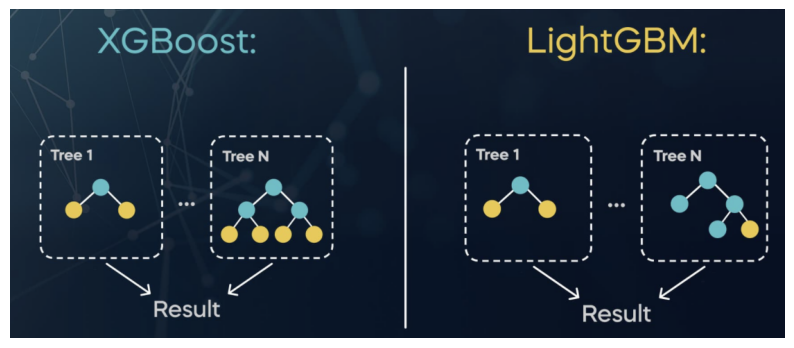

In [5]:
display_img('XGBoost_vs_LightGBM.png', 10, 10)

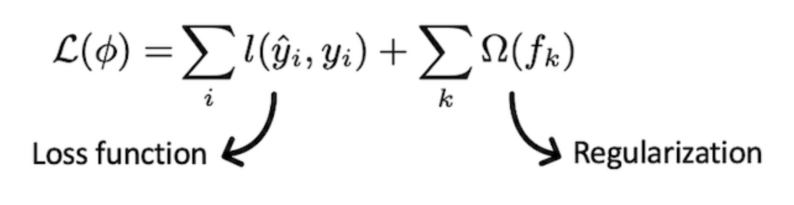

In [6]:
display_img('Formula.png', 10, 10)

**The regularization is to avoid overfitting.**

$ \Omega(f) = \gamma \cdot T + \cfrac{1}{2} \cdot \lambda \cdot || w ||^2  $

where $T$ is the number of leaves and $ w $ is the learning-weights.

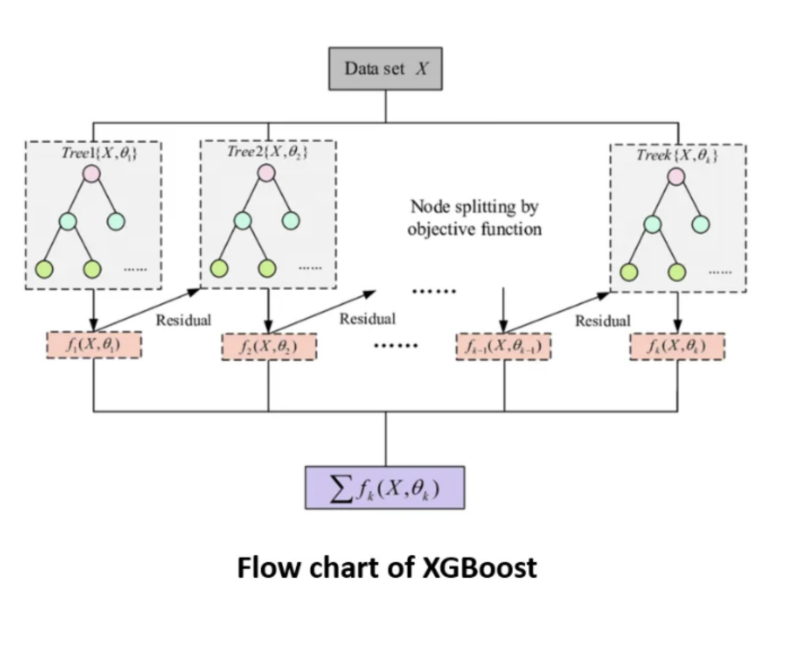

In [7]:
display_img('XGBoost.png', 10, 10)

**Steps:**

i. Create differents uncorrelated trees.

ii. Create the first model $f_1(x)$ [Level-Wise Growth] with the first subsample. Compute the first error $ e_1(x) $. 

iii. Create the second model $f_2(x)$ [Level-Wise Growth] with the second subsample to predict the first error $ e_1(x) $. The new predict is $ g_2(x) = f_2(x) + f_1(x) $. Compute the second error $ e_2(x) $.

iv. Create the third model $f_3(x)$ [Level-Wise Growth] with the third subsample to predict the second error $ e_2(x) $. The new predict is $ g_3(x) = g_2(x) + f_3(x) $. Compute the third error $ e_3(x) $.

v. Iterate.

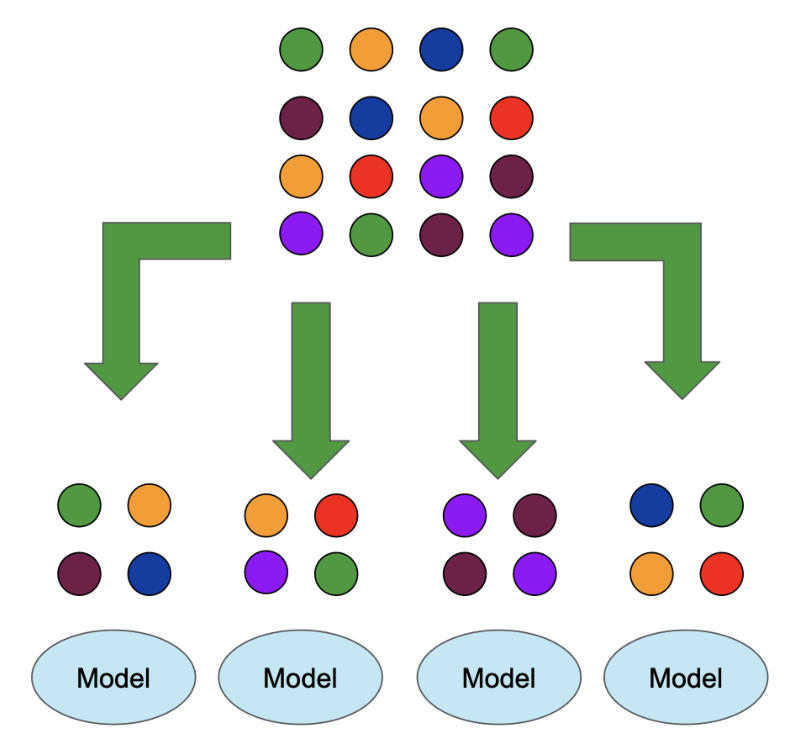

In [8]:
display_img('Boosting.png', 10, 10)

**Considerations:**

- The trees aren't sensitive to scaling.

In [9]:
start = time.time()

# 1. Preprocessing

### i. Read Dataframe

In [10]:
df = pd.read_csv('Life Expectancy Data.csv')

In [11]:
X_cols = var_dict['cat_oh'] + var_dict['num_mean']
y_col = ['Life expectancy ']

### ii. Drop 'y' NaNs

In [12]:
df = df[df[y_col[0]].notna()]

### iii. Split

In [13]:
# External

ctr_test_hor_ext = ['Argentina', 'Bolivia (Plurinational State of)', 'Brazil', 'Peru', 'Uruguay']

ctr_test_ver_ext = ['Chile', 'Colombia', 'Ecuador', 'Paraguay', 'Venezuela (Bolivarian Republic of)']

# Internal

ctr_test_hor_int = ['Dominica', 'Mauritius', 'Netherlands', 'Armenia', 'Kazakhstan', 'Russian Federation', 'Ukraine', 'Bangladesh', 'India', 'Somalia']

ctr_test_ver_int = ['Afghanistan', 'New Zealand', 'Niger', 'Nigeria', 'Norway', 'Oman', 'Pakistan', 'Panama', 'Papua New Guinea', 'Philippines']

# Validation

ctr_val_hor = ['Albania', 'Qatar', 'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Nicaragua', 'Poland', 'Portugal', 'Republic of Korea', 'Senegal', 'Republic of Moldova', 
               'Romania', 'Rwanda', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe', 'Morocco', 'Montenegro']

ctr_val_ver = ['Algeria', 'Luxembourg', 'Sierra Leone', 'Seychelles', 'Serbia', 'Saudi Arabia', 'Mongolia', 'Micronesia (Federated States of)', 'Mexico',
               'Mauritania', 'Malta', 'Mali', 'Maldives', 'Malaysia', 'Malawi', 'Madagascar', 'Lithuania', 'Slovakia', 'Libya', 'Liberia']

# All validation and test countries

all_ctr = ctr_test_hor_ext + ctr_test_ver_ext + ctr_test_hor_int + ctr_test_ver_int + ctr_val_hor + ctr_val_ver 

In [14]:
# External

df_test_hor_ext = df[(df['Country'].isin(ctr_test_hor_ext)) & (df['Year'] != 2015)]
df_test_ver_ext = df[(df['Country'].isin(ctr_test_ver_ext)) & (df['Year'] == 2015)]

# Internal

df_test_hor_int = df[(df['Country'].isin(ctr_test_hor_int)) & (df['Year'] != 2015)]
df_test_ver_int = df[(df['Country'].isin(ctr_test_ver_int)) & (df['Year'] == 2015)]

# Validation

df_val_hor = df[(df['Country'].isin(ctr_val_hor)) & (df['Year'] != 2015) & (df['Year'] != 2014)]
df_val_ver = df[(df['Country'].isin(ctr_val_ver)) & (df['Year'] == 2014)]

# Train

df_train = df[(~df['Country'].isin(all_ctr)) & (df['Year'] != 2015) & (df['Year'] != 2014)]

In [15]:
# External

X_test_hor_ext = df_test_hor_ext[X_cols]
y_test_hor_ext = df_test_hor_ext[y_col]

X_test_ver_ext = df_test_ver_ext[X_cols]
y_test_ver_ext = df_test_ver_ext[y_col]

# Internal

X_test_hor_int = df_test_hor_int[X_cols]
y_test_hor_int = df_test_hor_int[y_col]

X_test_ver_int = df_test_ver_int[X_cols]
y_test_ver_int = df_test_ver_int[y_col]

# Validation

X_val_hor = df_val_hor[X_cols]
y_val_hor = df_val_hor[y_col]

X_val_ver = df_val_ver[X_cols]
y_val_ver = df_val_ver[y_col]

# Train

X_train = df_train[X_cols]
y_train = df_train[y_col]

### iv. Fit preprocess

In [16]:
from preprocessing import *

In [17]:
transformers_fit = get_fit_transformers(var_dict, X_train)

In [18]:
# Train

y_train = y_train.reset_index()
y_train = y_train.drop(columns = ['index'])

# Validation

y_val_hor = y_val_hor.reset_index()
y_val_hor = y_val_hor.drop(columns = ['index'])

y_val_ver = y_val_ver.reset_index()
y_val_ver = y_val_ver.drop(columns = ['index'])

# Test

y_test_hor_int = y_test_hor_int.reset_index()
y_test_hor_int = y_test_hor_int.drop(columns = ['index'])

y_test_ver_int = y_test_ver_int.reset_index()
y_test_ver_int = y_test_ver_int.drop(columns = ['index'])

y_test_hor_ext = y_test_hor_ext.reset_index()
y_test_hor_ext = y_test_hor_ext.drop(columns = ['index'])

y_test_ver_ext = y_test_ver_ext.reset_index()
y_test_ver_ext = y_test_ver_ext.drop(columns = ['index'])

In [19]:
# Train

X_train = transform_datasets(transformers_fit, var_dict, X_train)

# Validation

X_val_hor = transform_datasets(transformers_fit, var_dict, X_val_hor)

X_val_ver = transform_datasets(transformers_fit, var_dict, X_val_ver)

# Test

X_test_hor_int = transform_datasets(transformers_fit, var_dict, X_test_hor_int)

X_test_ver_int = transform_datasets(transformers_fit, var_dict, X_test_ver_int)

X_test_hor_ext = transform_datasets(transformers_fit, var_dict, X_test_hor_ext)

X_test_ver_ext = transform_datasets(transformers_fit, var_dict, X_test_ver_ext)

### v. Train model (with Fine Tunning)

In [20]:
!pip install -q xgboost

In [21]:
from xgboost import XGBRegressor

In [22]:
N_est_max = 100
M_depth_max = 10

In [23]:
N_est = [i for i in range(1, N_est_max + 1)]
M_depth = [j for j in range(1, M_depth_max + 1)]

In [24]:
all_mape_train = []
all_mape_val = []
all_params = []


for n_est in N_est:

    print('N estimators: ', n_est)

    for m_depth in M_depth:

        reg = XGBRegressor(n_estimators = n_est, max_depth = m_depth, learning_rate = 0.2, random_state = 0)

        reg = reg.fit(X_train, y_train)

        y_train_pred = reg.predict(X_train)
        y_val_hor_pred = reg.predict(X_val_hor)
        y_val_ver_pred = reg.predict(X_val_ver)

        mape_train = round(abs((y_train_pred - y_train['Life expectancy '])/y_train['Life expectancy ']).mean()*100, 2)
        mape_val_hor = round(abs((y_val_hor_pred - y_val_hor['Life expectancy '])/y_val_hor['Life expectancy ']).mean()*100, 2)
        mape_val_ver = round(abs((y_val_ver_pred - y_val_ver['Life expectancy '])/y_val_ver['Life expectancy ']).mean()*100, 2)
        mape_val = (mape_val_hor + mape_val_ver)/2

        all_mape_train.append(mape_train)
        all_mape_val.append(mape_val)
        all_params.append([n_est, m_depth])
    
    print('-'*70)

all_mape_train = np.array(all_mape_train)
all_mape_val = np.array(all_mape_val)
all_params = np.array(all_params)

N estimators:  1
----------------------------------------------------------------------
N estimators:  2
----------------------------------------------------------------------
N estimators:  3
----------------------------------------------------------------------
N estimators:  4
----------------------------------------------------------------------
N estimators:  5
----------------------------------------------------------------------
N estimators:  6
----------------------------------------------------------------------
N estimators:  7
----------------------------------------------------------------------
N estimators:  8
----------------------------------------------------------------------
N estimators:  9
----------------------------------------------------------------------
N estimators:  10
----------------------------------------------------------------------
N estimators:  11
----------------------------------------------------------------------
N estimators:  12
------------

In [25]:
mape_train_opt = all_mape_train[all_mape_val == all_mape_val.min()][0]
mape_val_opt = all_mape_val[all_mape_val == all_mape_val.min()][0]
N_est_opt, M_depth_opt = all_params[all_mape_val == all_mape_val.min()][0]

In [26]:
print('Train MAPE:', mape_train_opt)
print('Val MAPE:', mape_val_opt)
print('N est opt:', N_est_opt)
print('M depth opt:', M_depth_opt)

Train MAPE: 1.42
Val MAPE: 2.995
N est opt: 28
M depth opt: 5


### vi. Train definitive model

In [27]:
reg = XGBRegressor(n_estimators = N_est_opt, max_depth = M_depth_opt, learning_rate = 0.2, random_state = 0)

In [28]:
reg = reg.fit(X_train, y_train)

### vii. Report of metrics

In [29]:
# Train

y_train_pred = reg.predict(X_train)
mape_train = round(abs((y_train_pred - y_train['Life expectancy '])/y_train['Life expectancy ']).mean()*100, 2)

# Validation

y_val_hor_pred = reg.predict(X_val_hor)
mape_val_hor = round(abs((y_val_hor_pred - y_val_hor['Life expectancy '])/y_val_hor['Life expectancy ']).mean()*100, 2)

y_val_ver_pred = reg.predict(X_val_ver)
mape_val_ver = round(abs((y_val_ver_pred - y_val_ver['Life expectancy '])/y_val_ver['Life expectancy ']).mean()*100, 2)

# Test 

y_test_hor_int_pred = reg.predict(X_test_hor_int)
mape_test_hor_int = round(abs((y_test_hor_int_pred - y_test_hor_int['Life expectancy '])/y_test_hor_int['Life expectancy ']).mean()*100, 2)

y_test_ver_int_pred = reg.predict(X_test_ver_int)
mape_test_ver_int = round(abs((y_test_ver_int_pred - y_test_ver_int['Life expectancy '])/y_test_ver_int['Life expectancy ']).mean()*100, 2)

y_test_hor_ext_pred = reg.predict(X_test_hor_ext)
mape_test_hor_ext = round(abs((y_test_hor_ext_pred - y_test_hor_ext['Life expectancy '])/y_test_hor_ext['Life expectancy ']).mean()*100, 2)

y_test_ver_ext_pred = reg.predict(X_test_ver_ext)
mape_test_ver_ext = round(abs((y_test_ver_ext_pred - y_test_ver_ext['Life expectancy '])/y_test_ver_ext['Life expectancy ']).mean()*100, 2)

In [30]:
print('Train')

print('\n')

print('MAPE Train:', mape_train)

print('\n')

print('-'*70)

print('Validation')

print('\n')

print('MAPE Val Hor:', mape_val_hor)
print('MAPE Val Ver:', mape_val_ver)

print('\n')

print('-'*70)

print('Test')

print('\n')

print('MAPE Test Hor Int:', mape_test_hor_int)
print('MAPE Test Ver Int:', mape_test_ver_int)
print('MAPE Test Hor Ext:', mape_test_hor_ext)
print('MAPE Test Ver Ext:', mape_test_ver_ext)

print('\n')

print('-'*70)

Train


MAPE Train: 1.42


----------------------------------------------------------------------
Validation


MAPE Val Hor: 2.72
MAPE Val Ver: 3.27


----------------------------------------------------------------------
Test


MAPE Test Hor Int: 4.46
MAPE Test Ver Int: 2.88
MAPE Test Hor Ext: 2.3
MAPE Test Ver Ext: 1.45


----------------------------------------------------------------------


### viii. Patterns

In [31]:
X_test_hor_int['pred'] = y_test_hor_int
X_test_ver_int['pred'] = y_test_ver_int
X_test_hor_ext['pred'] = y_test_hor_ext
X_test_ver_ext['pred'] = y_test_ver_ext

In [32]:
df_patt = pd.concat([X_test_hor_int, X_test_ver_int, X_test_hor_ext, X_test_ver_ext], axis = 0)
df_patt = df_patt.reset_index()
df_patt = df_patt.drop(columns = ['index'])

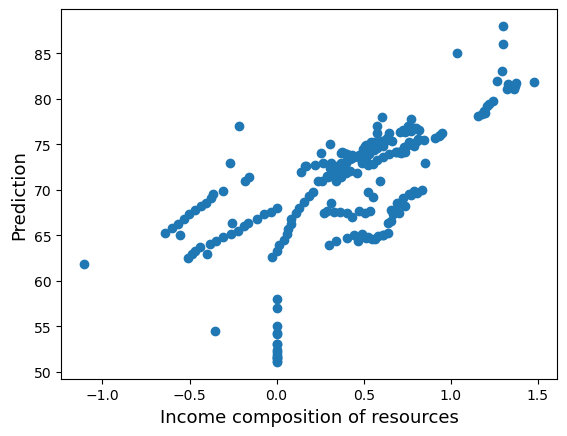

In [33]:
plt.scatter(df_patt['Income composition of resources'], df_patt['pred'])
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Income composition of resources', fontsize = 13)
plt.show()

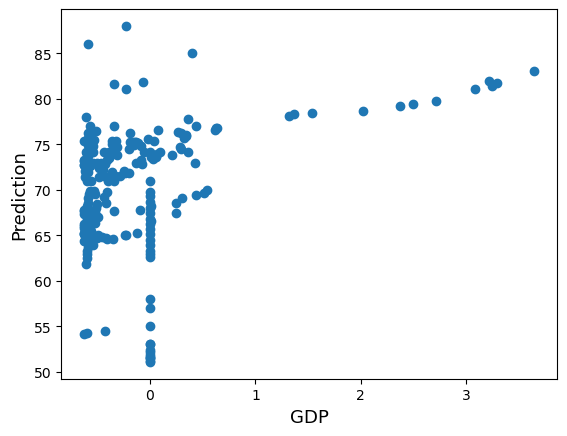

In [34]:
plt.scatter(df_patt['GDP'], df_patt['pred'])
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('GDP', fontsize = 13)
plt.show()

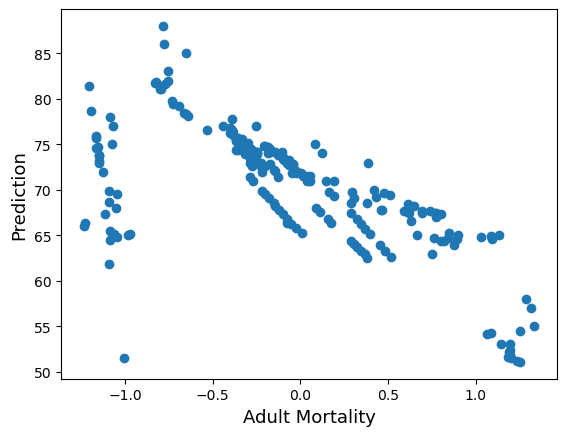

In [35]:
plt.scatter(df_patt['Adult Mortality'], df_patt['pred'])
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Adult Mortality', fontsize = 13)
plt.show()

### ix. Feature Importance

In [36]:
fi = pd.DataFrame(zip(reg.feature_names_in_, reg.feature_importances_))
fi = fi.rename(columns = {0: 'Variable', 1: 'Importance'})
fi['Importance'] = fi['Importance']*100

fi = fi.sort_values(by = ['Importance'], ascending = False)
fi = fi.reset_index()
fi = fi.drop(columns = ['index'])

In [37]:
fi

,Variable,Importance
0,HIV/AIDS,71.498444
1,Income composition of resources,12.371893
2,Diphtheria,4.784701
3,Adult Mortality,3.648463
4,thinness 5-9 years,1.701079
5,under-five deaths,1.447623
6,BMI,1.431382
7,Alcohol,0.802901
8,Population,0.440188
9,Year,0.402191


### x. Explainability

In [38]:
import shap

In [39]:
explainer = shap.TreeExplainer(reg)

In [40]:
shap_values = explainer.shap_values(df_patt[X_train.columns])

In [41]:
df_shap_values = pd.DataFrame(shap_values)
df_shap_values.columns = X_train.columns

**Importance Variable**

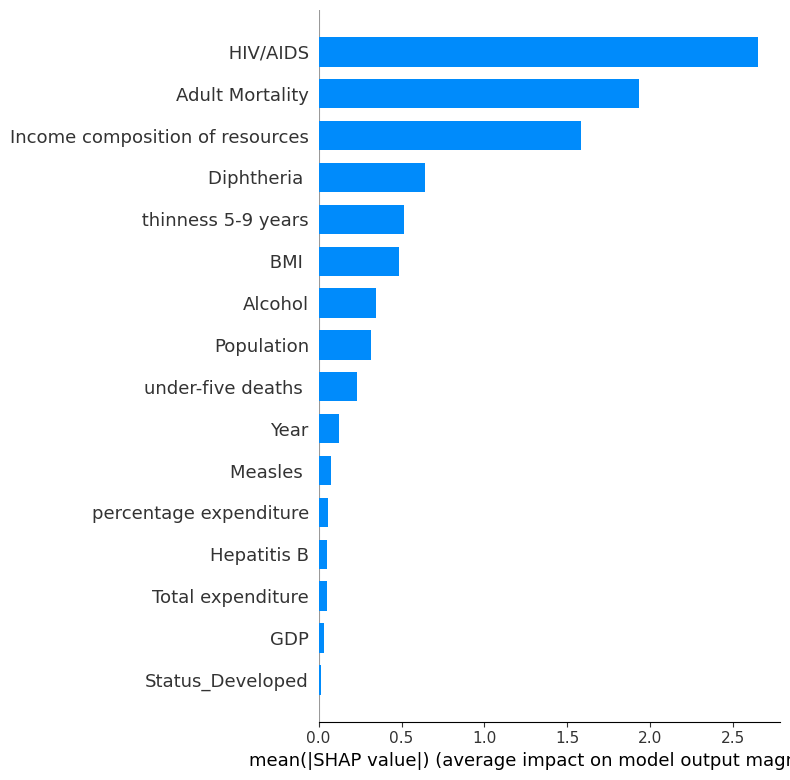

In [42]:
shap.summary_plot(shap_values, df_patt[X_train.columns], plot_type = "bar")

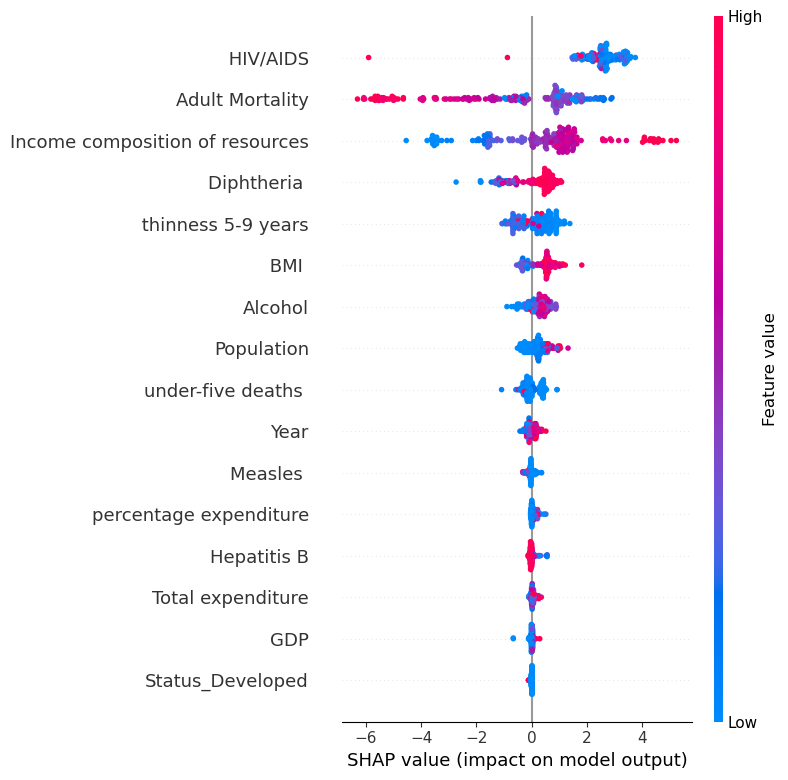

In [43]:
shap.summary_plot(shap_values, df_patt[X_train.columns])

In [44]:
df_shap_values['partial_sum_SHAP'] = df_shap_values.sum(axis = 1)

In [45]:
df_shap_values = df_shap_values[['partial_sum_SHAP']]

In [46]:
df_shap_values['pred_model'] = df_patt['pred']

**Sum of SHAP Values**

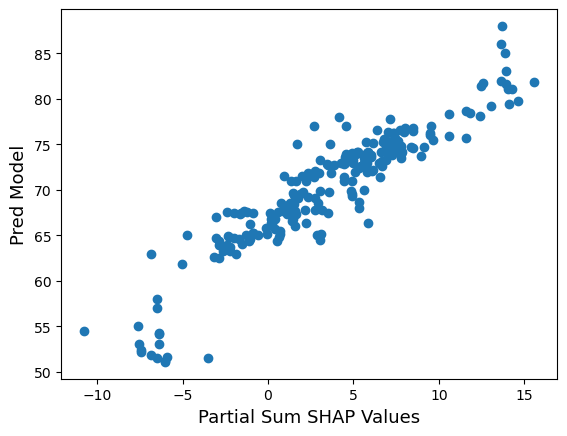

In [47]:
plt.scatter(df_shap_values['partial_sum_SHAP'], df_shap_values['pred_model'])
plt.xlabel('Partial Sum SHAP Values', fontsize = 13)
plt.ylabel('Pred Model', fontsize = 13)
plt.show()

**SHAP dependency**

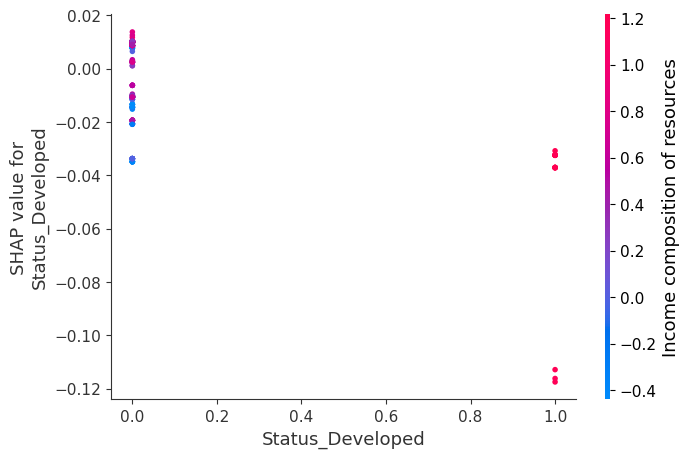

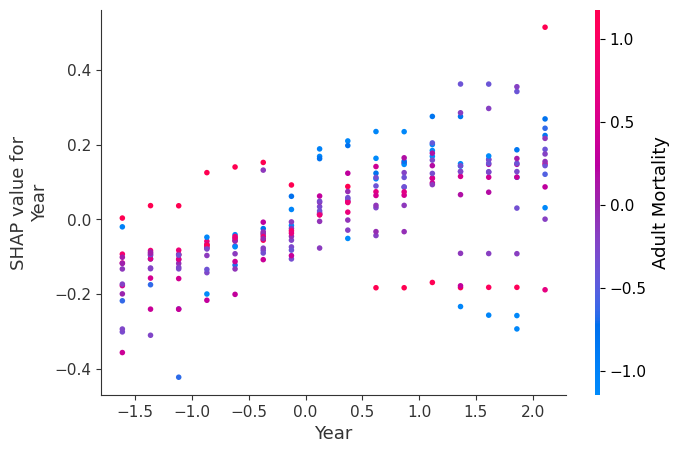

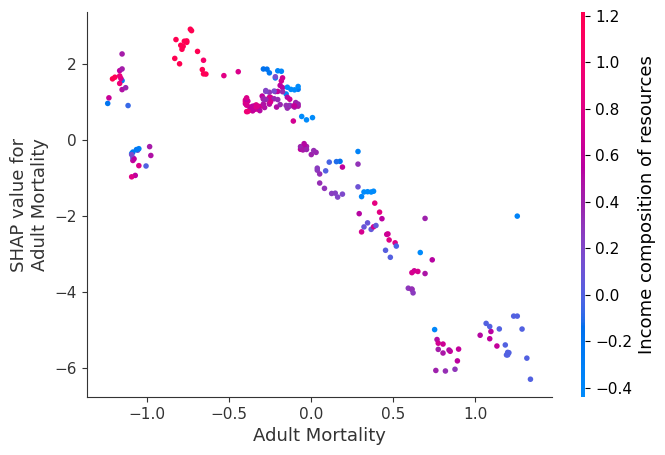

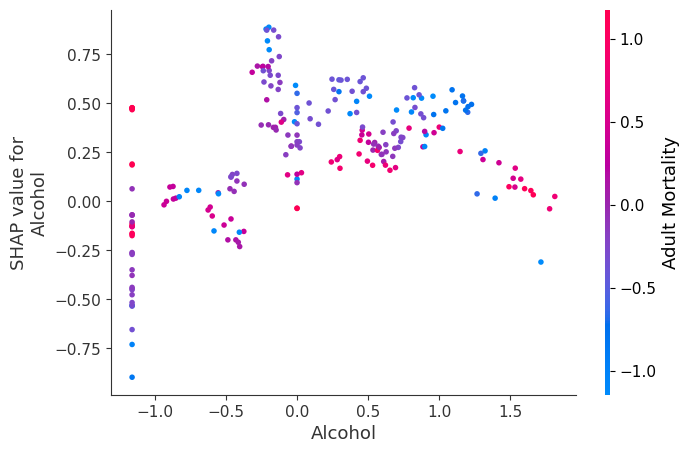

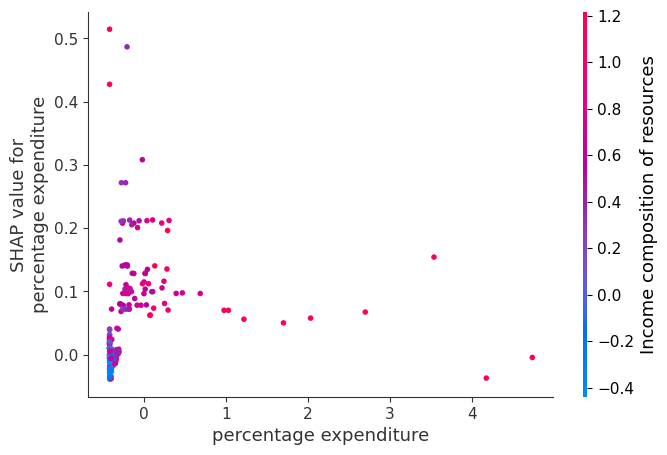

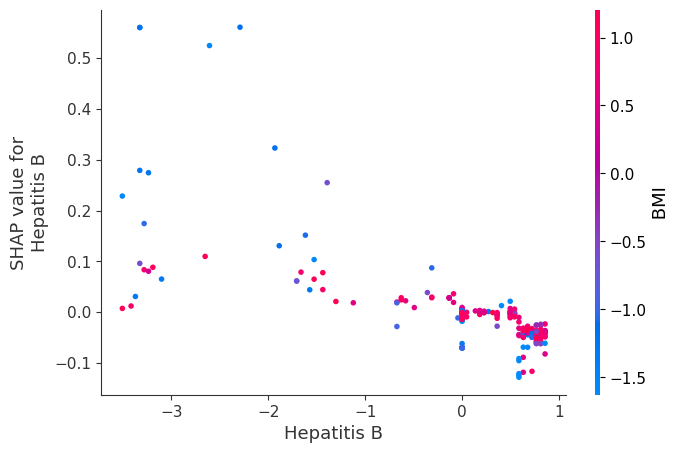

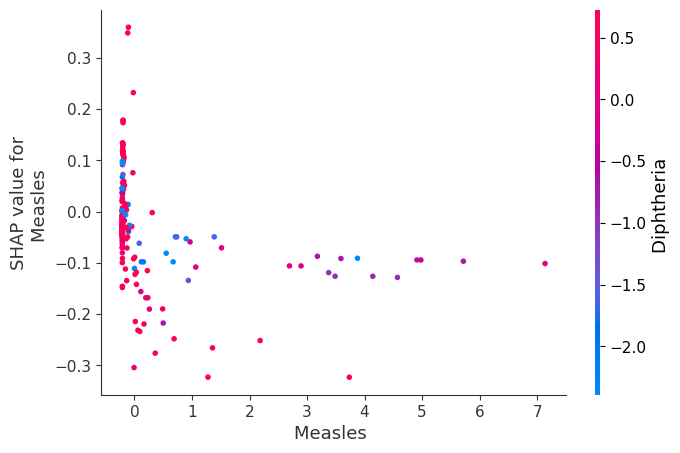

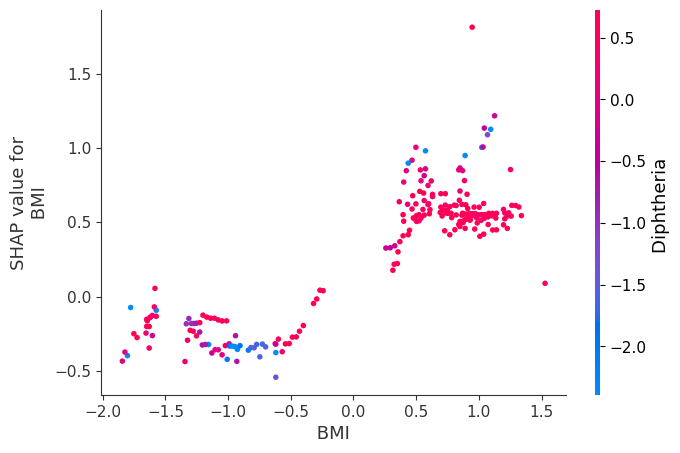

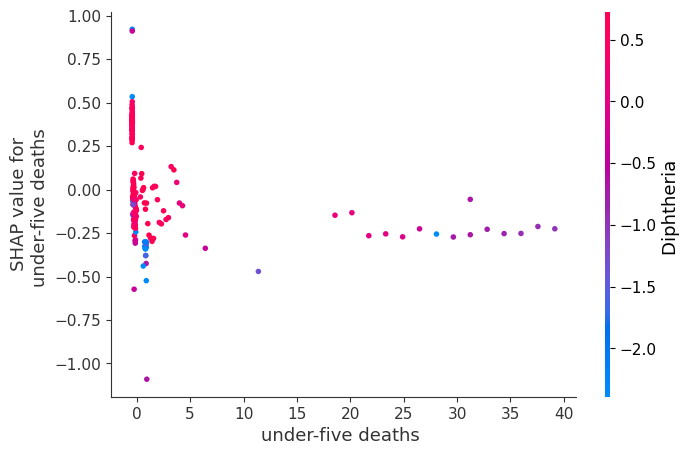

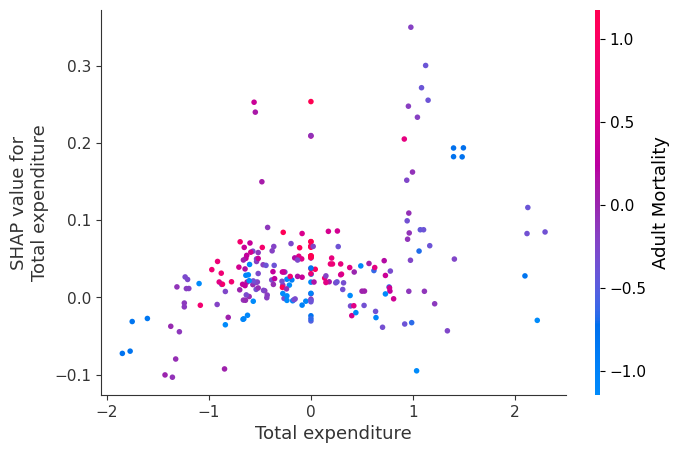

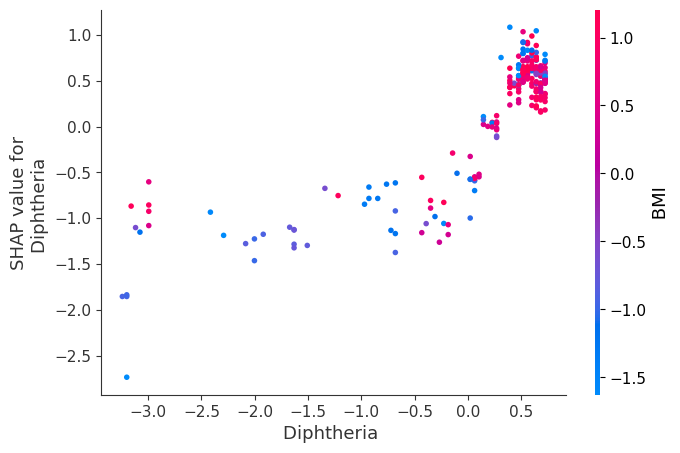

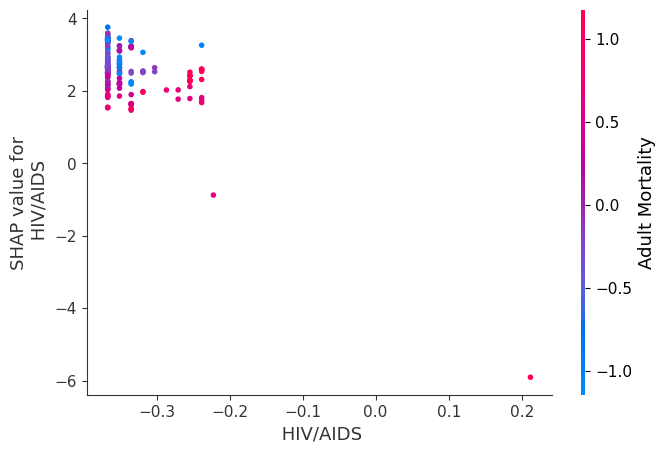

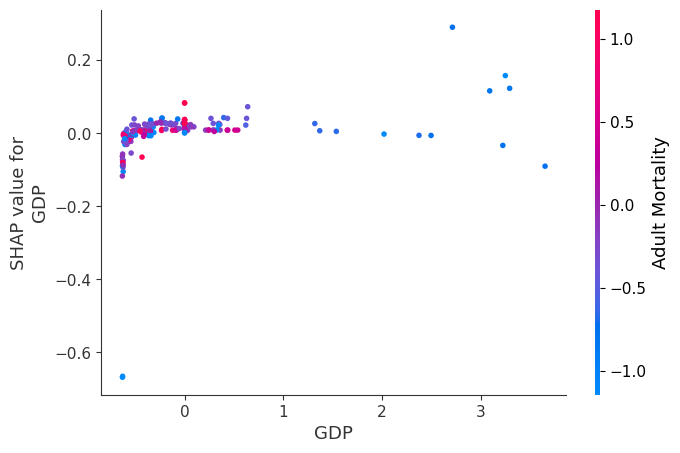

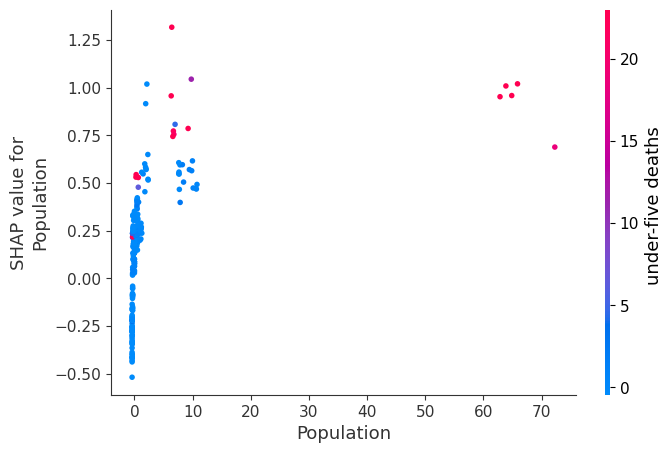

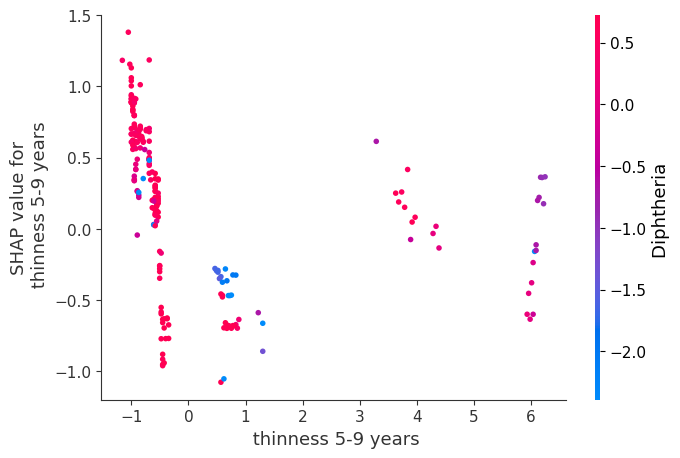

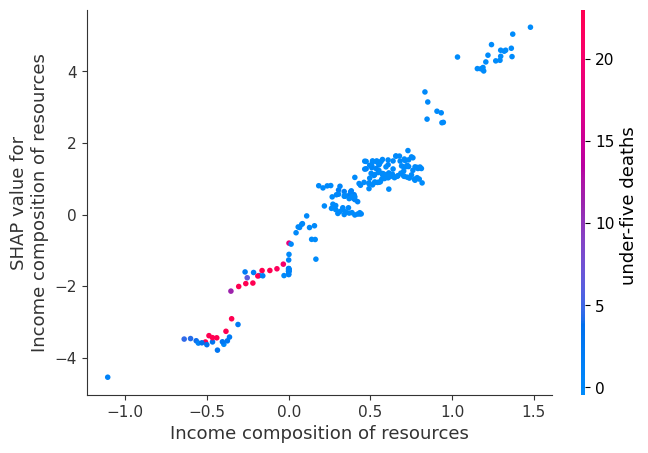

In [48]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, df_patt[X_train.columns])

### Time of execution

In [49]:
end = time.time()

In [50]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 1 minutes and 6 seconds.
